
# Reinforcement Learning Project – Blackjack (Discrete Environment)

## Environment Overview
In this part of the project, we address the **Blackjack-v1** environment from Gymnasium. This environment simulates the popular card game, where the agent must decide whether to "hit" or "stick" to reach a sum close to 21, without exceeding it. The game is simple yet involves probabilistic reasoning, making it an ideal setting for comparing different reinforcement learning methods.

### Environment Characteristics:
- **Observation space**: Tuple of 3 discrete values:  
  - Player's current sum (0–32)  
  - Dealer's showing card (1–10)  
  - Usable ace (True/False)  
- **Action space**:  
  - 0 = Stick  
  - 1 = Hit  

## Algorithms Implemented
To explore how different learning strategies behave in a discrete setting, we implement and compare the following algorithms:
1. **Q-Learning** – A model-free, off-policy method based on value iteration.  
2. **Monte Carlo Control** – A model-free, on-policy method based on episode returns.





<div style="text-align: center;">
    <strong style="display: block; margin-bottom: 10px;">Group ??</strong> 
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Joana Rodrigues</td>
            <td style="border: 1px solid white; padding: 8px;">20240603</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Mara Simões</td>
            <td style="border: 1px solid white; padding: 8px;">20240326</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Matilde Street</td>
            <td style="border: 1px solid white; padding: 8px;">20240523</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Tomás Luzia</td>
            <td style="border: 1px solid white; padding: 8px;">20230477</td>
        </tr>
    </table>
</div>

### 🔗 Table of Contents <a id='table-of-contents'></a>
1. [Imports](#imports)
---

# 1. Common functions

## 1.1. Imports

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import itertools
from mpl_toolkits.mplot3d import Axes3D
import random
from collections import defaultdict



## 1.2. Definition of environment and parameters

In [50]:
env = gym.make("Blackjack-v1")
num_episodes = 500000

## 1.3. ε-Greedy Policy

In [51]:
def epsilon_greedy_policy(Q, state, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)  # Explorar
    return np.argmax(Q[state])             # Exploitar

def decay_epsilon(epsilon, decay_rate=0.99999, min_epsilon=0.05):
    return max(min_epsilon, epsilon * decay_rate)

## 1.4. Evaluation functions

In [52]:
def moving_avg(rewards_per_episode):
    window = 1000
    moving_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

    plt.plot(moving_avg)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Q-Learning: Moving Average Reward per Episode')
    plt.grid()
    plt.show()

In [53]:
def evaluate_policy(env, policy, num_episodes=10000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            # Use default action=1 (stick) if state unseen in policy
            action = policy.get(state, 1)  # default to hit if state unseen
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    print(f"After {num_episodes} episodes:")
    print(f"Wins: {wins} ({wins/num_episodes:.2%})")
    print(f"Losses: {losses} ({losses/num_episodes:.2%})")
    print(f"Draws: {draws} ({draws/num_episodes:.2%})")

    return wins, losses, draws

In [54]:
def plot_value_function(V, usable_ace=True):
    value_grid = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            state = (player_sum, dealer_card, usable_ace)
            value_grid[player_sum - 12, dealer_card - 1] = V.get(state, 0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(value_grid, annot=True, cmap="coolwarm", xticklabels=range(1, 11), yticklabels=range(12, 22))
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    plt.title(f"Value Function - {'Usable Ace' if usable_ace else 'No Usable Ace'}")
    plt.show()

# 2. Q-Learning

 Q-Learning Training Loop


In [55]:
def q_learning(env, num_episodes, alpha, gamma, epsilon, seed=7):
    np.random.seed(seed)

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []

    for i_episode in range(1, num_episodes + 1):
        state, _ = env.reset(seed=seed + i_episode)
        done = False

        episode_reward = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            best_next = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next] if not done else reward
            Q[state][action] += alpha * (td_target - Q[state][action])

            state = next_state
            episode_reward += reward

        rewards_per_episode.append(episode_reward)
        epsilon = decay_epsilon(epsilon)

    # V(s) = max_a Q(s,a)
    V = {s: np.max(a) for s, a in Q.items()} #value
    return Q, rewards_per_episode, V


Grid search to define hyperparameters

In [30]:
param_grid = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
    'gamma': [0.9, 0.95, 0.99],
    'epsilon': [0.05, 0.1, 0.2]}

# Prepare all combinations
param_combinations = list(itertools.product(
    param_grid['alpha'],
    param_grid['gamma'],
    param_grid['epsilon']
))

results = {}

for alpha, gamma, epsilon in param_combinations:
    print(f"Running Q-learning with alpha={alpha}, gamma={gamma}, epsilon={epsilon} ...")
    Q, rewards_per_episode, V = q_learning(env, num_episodes=10000, alpha=alpha, gamma=gamma, epsilon=epsilon)
    
    final_avg = np.mean(rewards_per_episode[-500:])  # Average over last 500 episodes
    print(f"Average reward (last 500 episodes): {final_avg:.4f}\n")

    key = f"alpha_{alpha}_gamma_{gamma}_epsilon_{epsilon}"
    results[key] = {
        'Q': Q,
        'rewards_per_episode': rewards_per_episode,
        'V': V,
        'final_avg_reward': final_avg
    }

# Find best combination
best_key = max(results, key=lambda k: results[k]['final_avg_reward'])
best_avg = results[best_key]['final_avg_reward']

print(f"\033[1mBest combination was:\033[0m {best_key}")
print(f"\033[1mWith average reward (last 500 episodes):\033[0m {best_avg:.4f}")



Running Q-learning with alpha=0.1, gamma=0.9, epsilon=0.05 ...
Average reward (last 500 episodes): -0.1000

Running Q-learning with alpha=0.1, gamma=0.9, epsilon=0.1 ...
Average reward (last 500 episodes): -0.1200

Running Q-learning with alpha=0.1, gamma=0.9, epsilon=0.2 ...
Average reward (last 500 episodes): -0.1320

Running Q-learning with alpha=0.1, gamma=0.95, epsilon=0.05 ...
Average reward (last 500 episodes): -0.0880

Running Q-learning with alpha=0.1, gamma=0.95, epsilon=0.1 ...
Average reward (last 500 episodes): -0.1220

Running Q-learning with alpha=0.1, gamma=0.95, epsilon=0.2 ...
Average reward (last 500 episodes): -0.1520

Running Q-learning with alpha=0.1, gamma=0.99, epsilon=0.05 ...
Average reward (last 500 episodes): -0.0340

Running Q-learning with alpha=0.1, gamma=0.99, epsilon=0.1 ...
Average reward (last 500 episodes): -0.1460

Running Q-learning with alpha=0.1, gamma=0.99, epsilon=0.2 ...
Average reward (last 500 episodes): -0.1440

Running Q-learning with alph

In [56]:
# Best combination was: alpha_0.1_gamma_0.99_epsilon_0.05
# With average reward (last 500 episodes): -0.0340

Q, rewards_per_episode, V_q = q_learning(env, num_episodes, 0.1, 0.99, 0.05)
print("Average reward (last 1000 episodes):", np.mean(rewards_per_episode[-1000:]))

Average reward (last 1000 episodes): -0.071


Policy

In [8]:
optimal_policy = {s: np.argmax(a) for s, a in Q.items()}

### Results

In [57]:
print("Q value stats:")
all_values = []
for actions in Q.values():
    all_values.extend(actions)
print(f"Min Q-value: {np.min(all_values)}")
print(f"Max Q-value: {np.max(all_values)}")
print(f"Mean Q-value: {np.mean(all_values)}")

print("V(s) stats:")
print(f"Min V-value: {min(V_q.values())}")
print(f"Max V-value: {max(V_q.values())}")
print(f"Mean V-value: {np.mean(list(V_q.values()))}")


Q value stats:
Min Q-value: -0.999999999949352
Max Q-value: 0.9999999956991353
Mean Q-value: -0.17200036227097296
V(s) stats:
Min V-value: -0.7279631309253258
Max V-value: 0.9999999956991353
Mean V-value: 0.014213999463515765


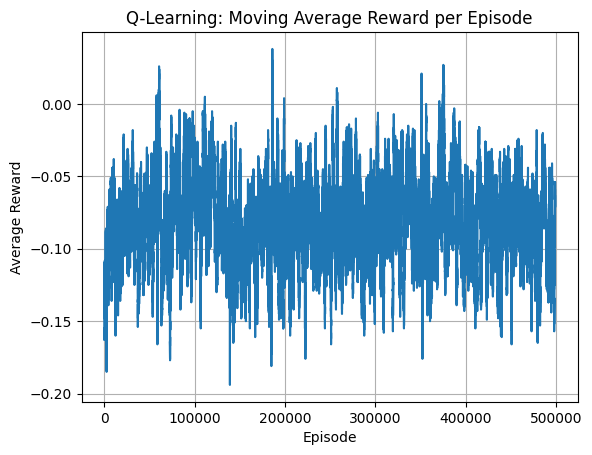

In [58]:
moving_avg(rewards_per_episode)

Plot Value Function as Heatmap

In [ ]:

# Evaluate the learned policy
wins, losses, draws = evaluate_policy(env, optimal_policy)


After 10000 episodes:
Wins: 4035 (40.35%)
Losses: 5026 (50.26%)
Draws: 939 (9.39%)


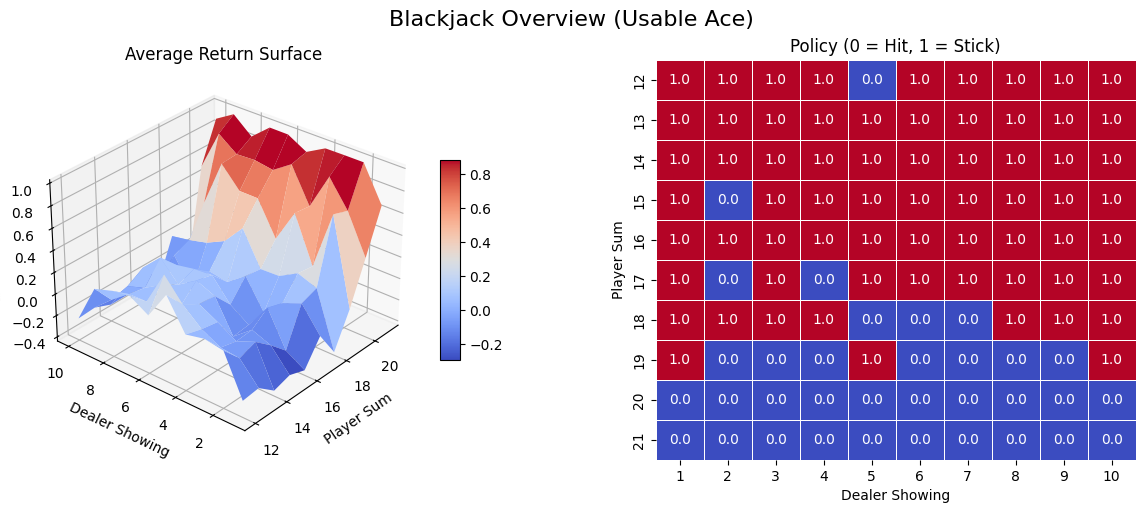

In [ ]:

def create_value_policy_grids_optimized(Q, V, usable_ace=False):
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)

    value_grid = np.zeros((len(player_sums), len(dealer_cards)))
    policy_grid = np.zeros((len(player_sums), len(dealer_cards)))

    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = (player_sum, dealer_card, usable_ace)
            if state in Q:
                value_grid[i, j] = V[state]
                policy_grid[i, j] = np.argmax(Q[state])
            else:
                value_grid[i, j] = 0
                policy_grid[i, j] = 0

    return player_sums, dealer_cards, value_grid, policy_grid

def create_avg_return_grid(V, usable_ace=False):
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)
    avg_return_grid = np.zeros((len(player_sums), len(dealer_cards)))

    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = (player_sum, dealer_card, usable_ace)
            if state in V:
                avg_return_grid[i, j] = V[state]
            else:
                avg_return_grid[i, j] = np.nan

    return player_sums, dealer_cards, avg_return_grid


def plot_return_and_policy(player_sums, dealer_cards, value_grid, policy_grid,
                           avg_return_grid, title):
    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(title, fontsize=16)

    # 1. 3D Average Return Surface
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    X, Y = np.meshgrid(dealer_cards, player_sums)
    surf = ax1.plot_surface(Y, X, avg_return_grid, cmap='coolwarm', edgecolor='none')
    ax1.set_xlabel('Player Sum')
    ax1.set_ylabel('Dealer Showing')
    ax1.set_zlabel('Avg Return')
    ax1.set_title('Average Return Surface')
    ax1.view_init(30, 220)
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10)

    # 2. Policy Heatmap
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, xticklabels=dealer_cards, yticklabels=player_sums,
                cmap='coolwarm', cbar=False, linewidths=0.5, annot=True, fmt='.1f',
                vmin=0, vmax=1, ax=ax2)
    ax2.set_xlabel('Dealer Showing')
    ax2.set_ylabel('Player Sum')
    ax2.set_title('Policy (0 = Hit, 1 = Stick)')

    plt.subplots_adjust(wspace=0.3, left=0.05, right=0.97, top=0.88, bottom=0.08)
    plt.show()

player_sums, dealer_cards, value_grid, policy_grid = create_value_policy_grids_optimized(Q, V_q, usable_ace=True)
player_sums, dealer_cards, avg_return_grid = create_avg_return_grid(V_q, usable_ace=True)

plot_return_and_policy(
    player_sums, dealer_cards,
    value_grid, policy_grid,
    avg_return_grid,
    title='Blackjack Overview (Usable Ace)'
)

plot_value_function(V_q, usable_ace=True)

In [ ]:
def double_q_learning(env, num_episodes, alpha, gamma, epsilon, seed=7):
    np.random.seed(seed)

    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []

    for i_episode in range(1, num_episodes + 1):
        state, _ = env.reset(seed=seed + i_episode)
        done = False
        episode_reward = 0

        while not done:
            # Escolher ação baseada na soma dos Qs
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space.n)
            else:
                action = np.argmax(Q1[state] + Q2[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if np.random.rand() < 0.5:
                # Atualiza Q1
                best_next_action = np.argmax(Q1[next_state])
                td_target = reward + gamma * Q2[next_state][best_next_action] if not done else reward
                Q1[state][action] += alpha * (td_target - Q1[state][action])
            else:
                # Atualiza Q2
                best_next_action = np.argmax(Q2[next_state])
                td_target = reward + gamma * Q1[next_state][best_next_action] if not done else reward
                Q2[state][action] += alpha * (td_target - Q2[state][action])

            state = next_state
            episode_reward += reward

        rewards_per_episode.append(episode_reward)
        epsilon = decay_epsilon(epsilon)

    # Política ótima final
    Q_final = defaultdict(lambda: np.zeros(env.action_space.n))
    for s in set(Q1.keys()).union(Q2.keys()):
        Q_final[s] = (Q1[s] + Q2[s]) / 2

    V = {s: np.max(Q_final[s]) for s in Q_final}

    return Q_final, rewards_per_episode, V

Q_double, rewards_per_episode_double, V_double = double_q_learning(env, num_episodes, 0.1, 0.99, 0.05)

print("Average reward (last 1000 episodes):", np.mean(rewards_per_episode_double[-1000:]))

optimal_policy_double = {s: np.argmax(a) for s, a in Q_double.items()}

Average reward (last 1000 episodes): -0.062


In [36]:
optimal_policy_double = {s: np.argmax(a) for s, a in Q_double.items()}

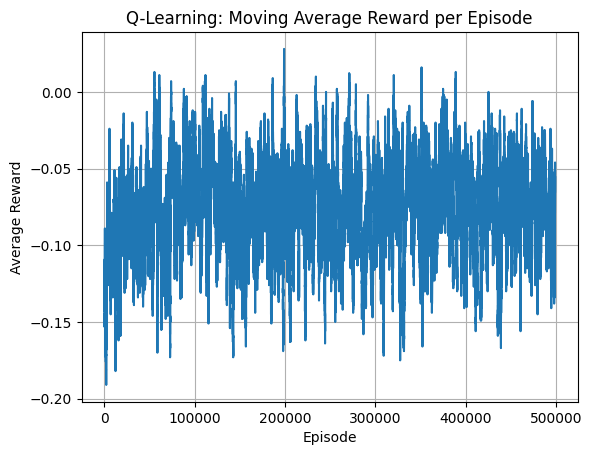

After 10000 episodes:
Wins: 4313 (43.13%)
Losses: 4829 (48.29%)
Draws: 858 (8.58%)


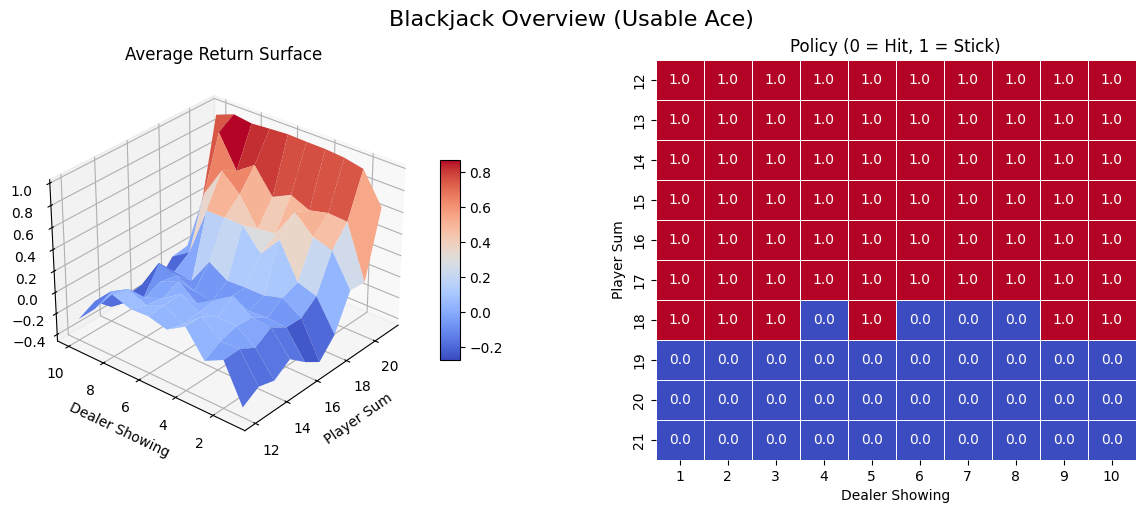

In [ ]:
moving_avg(rewards_per_episode_double)
wins, losses, draws = evaluate_policy(env, optimal_policy_double)

player_sums, dealer_cards, value_grid, policy_grid = create_value_policy_grids_optimized(Q_double, V_double)
player_sums, dealer_cards, avg_return_grid = create_avg_return_grid(V_double)

plot_return_and_policy(
    player_sums, dealer_cards,
    value_grid, policy_grid,
    avg_return_grid,
    title='Blackjack Performance Overview'
)

plot_value_function(V_double, usable_ace=True)

# 3. Monte Carlo

##  PARA O Relatório

- Explicar que Monte Carlo depende de episódios completos e não usa bootstrap.
- Destacar que não precisa de conhecimento do modelo do ambiente.
- Mostrar que a política evolui ao longo do tempo baseada nos retornos observados.
- Comparar a performance com o Q-learning (velocidade de convergência, estabilidade, etc.).

Initialization of the environment, parameters to use and structures

In [ ]:
gamma = 1.0  
epsilon = 0.1  

returns_sum = defaultdict(float)
returns_count = defaultdict(float)
Q = defaultdict(lambda: np.zeros(env.action_space.n))

Epsilon-Greedy Policy Function

In [16]:
def epsilon_greedy_policy(Q, state, nA, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)  
    else:
        return np.argmax(Q[state])   


Monte Carlo Control (On-policy First-Visit)

In [38]:
def monte_carlo_control(env, num_episodes, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # To track returns for averaging
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # Track episode rewards for plotting
    episode_rewards = []

    for episode in tqdm(range(num_episodes)):
        episode_data = []
        state = env.reset()[0]
        done = False

        # Generate an episode
        while not done:
            action = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_data.append((state, action, reward))
            state = next_state

        episode_rewards.append(episode_data[-1][2])  # final reward

        # Track first-visit returns
        visited = set()
        G = 0

        for t in reversed(range(len(episode_data))):
            state_t, action_t, reward_t = episode_data[t]
            G = gamma * G + reward_t

            if (state_t, action_t) not in visited:
                visited.add((state_t, action_t))
                returns_sum[(state_t, action_t)] += G
                returns_count[(state_t, action_t)] += 1
                Q[state_t][action_t] = returns_sum[(state_t, action_t)] / returns_count[(state_t, action_t)]

    return Q, episode_rewards


Training the agent

In [ ]:
Q_mc, mc_rewards = monte_carlo_control(env, num_episodes=50000)


  0%|          | 0/50000 [00:00<?, ?it/s]

Extract the Policy and Value Function

In [ ]:
def extract_policy(Q):
    policy = {}
    for state, actions in Q.items():
        policy[state] = np.argmax(actions)
    return policy

def compute_value_function(Q):
    V = defaultdict(float)
    for state, actions in Q.items():
        V[state] = np.max(actions)
    return V

policy_mc = extract_policy(Q_mc)
V_mc = compute_value_function(Q_mc)

Analyze Results

In [41]:
print("Average reward (last 1000 episodes):", np.mean(mc_rewards[-1000:]))

Average reward (last 1000 episodes): -0.083


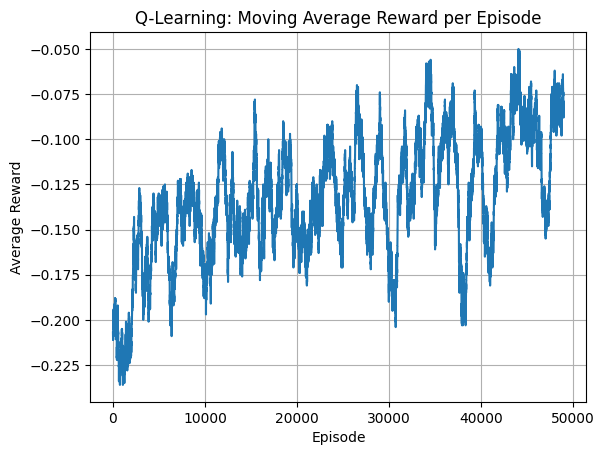

After 10000 episodes:
Wins: 4202 (42.02%)
Losses: 4988 (49.88%)
Draws: 810 (8.10%)


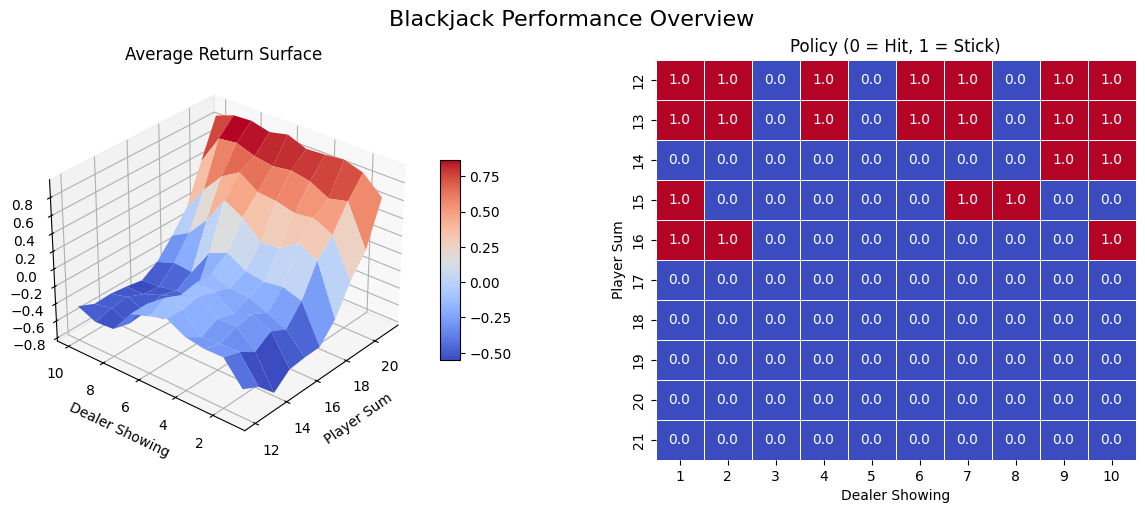

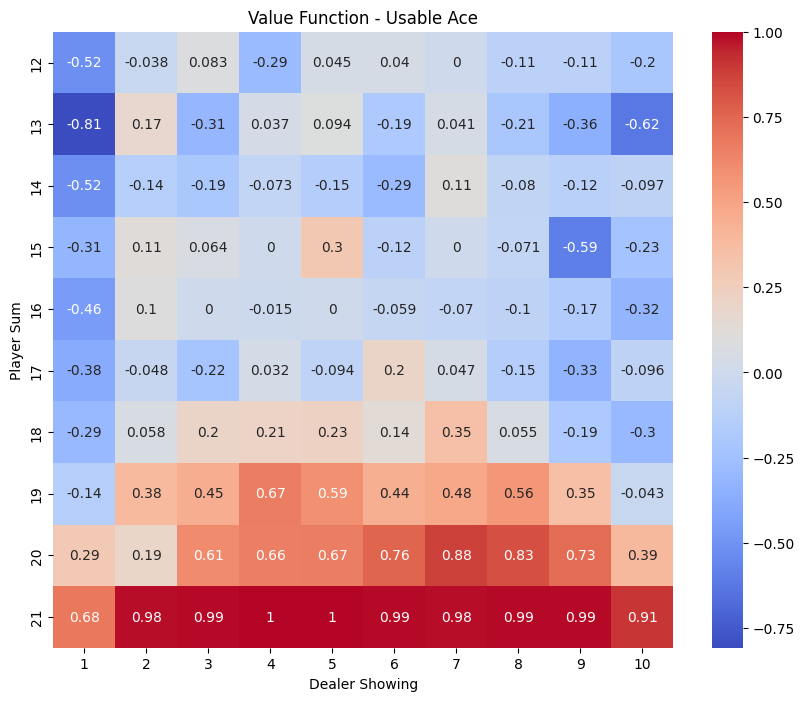

In [46]:
moving_avg(mc_rewards)
optimal_policy_mc = {s: np.argmax(a) for s, a in Q_mc.items()}
wins, losses, draws = evaluate_policy(env, optimal_policy_mc)

player_sums, dealer_cards, value_grid, policy_grid = create_value_policy_grids_optimized(Q_mc, V_mc)
player_sums, dealer_cards, avg_return_grid = create_avg_return_grid(V_mc)

plot_return_and_policy(
    player_sums, dealer_cards,
    value_grid, policy_grid,
    avg_return_grid,
    title='Blackjack Performance Overview'
)

plot_value_function(V_mc, usable_ace=True)

### Conclusions
1. MC Moving average

The plot above shows the rolling average reward (window = 1000 episodes) over 500,000 training episodes using the Monte Carlo Control method. Despite some fluctuations due to the stochastic nature of the Blackjack environment and ε-greedy exploration, the agent demonstrates a gradual improvement in performance. Over time, the average reward stabilizes around **-0.06**, indicating that the learned policy performs reasonably well, though the environment remains slightly biased against the player.

2. Heatmaps

The heatmaps show the estimated state value functions (V(s) = max_a Q(s, a)) learned by the Monte Carlo agent, split by whether the player has a usable ace or not:
The presence of a usable ace generally leads to higher expected returns, confirming the strategic value of flexible Aces in Blackjack.

## 4. Comparison between Q-Learning and Monte Carlo

In this section, we compare the performance of **Monte Carlo Control** and **Q-Learning**, applied to the `Blackjack-v1` environment from OpenAI Gym. Both agents were trained for 500,000 episodes using ε-greedy exploration strategies.

The comparison focuses on the average reward obtained in the final episodes of training, which reflects the quality of the learned policies.

| Algorithm           | Average Reward (Last 1000 Episodes) |
|---------------------|--------------------------------------|
| Monte Carlo Control | -0.07                                |
| Q-Learning          | -0.071                               |


Q-Learning average reward (last 1000 episodes): -0.0710
Monte Carlo average reward (last 1000 episodes): -0.0910


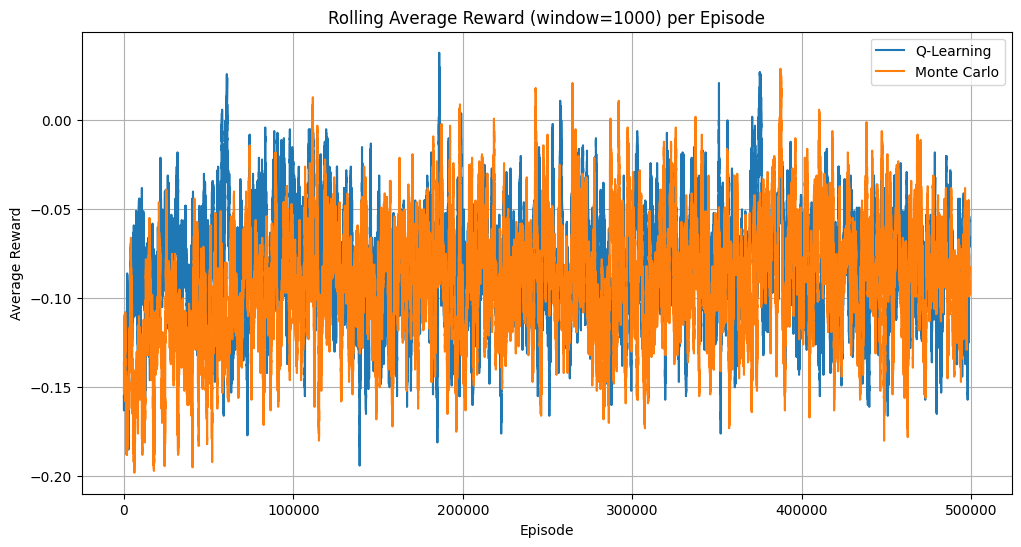

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute average reward over last 1000 episodes for both agents
q_avg_reward = np.mean(rewards_per_episode[-1000:])
mc_avg_reward = np.mean(mc_rewards[-1000:])

print(f"Q-Learning average reward (last 1000 episodes): {q_avg_reward:.4f}")
print(f"Monte Carlo average reward (last 1000 episodes): {mc_avg_reward:.4f}")

# Plot rolling average reward with window size 1000 for smoother visualization
window = 1000
q_rolling_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')
mc_rolling_avg = np.convolve(mc_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12,6))
plt.plot(q_rolling_avg, label='Q-Learning')
plt.plot(mc_rolling_avg, label='Monte Carlo')
plt.title('Rolling Average Reward (window=1000) per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()


The results indicate that **Monte Carlo Control** outperformed **Q-Learning** in terms of average reward in the final phase of training. This suggests that Monte Carlo Control learned a more effective policy in this environment.

While Q-Learning typically converges faster due to its bootstrapping nature and updates after each step, it may be less stable in highly stochastic, episodic environments like Blackjack. In contrast, Monte Carlo methods benefit from complete episode returns, making them better suited for episodic tasks with clearly defined episode boundaries.

In conclusion, while both methods successfully learned policies in the Blackjack environment, **Monte Carlo Control** achieved better final performance. Its ability to utilize full-episode returns gave it an advantage in this task, despite potentially slower initial learning. Therefore, for episodic environments with high variance like Blackjack, Monte Carlo methods can be more suitable than TD-based approaches such as Q-Learning.


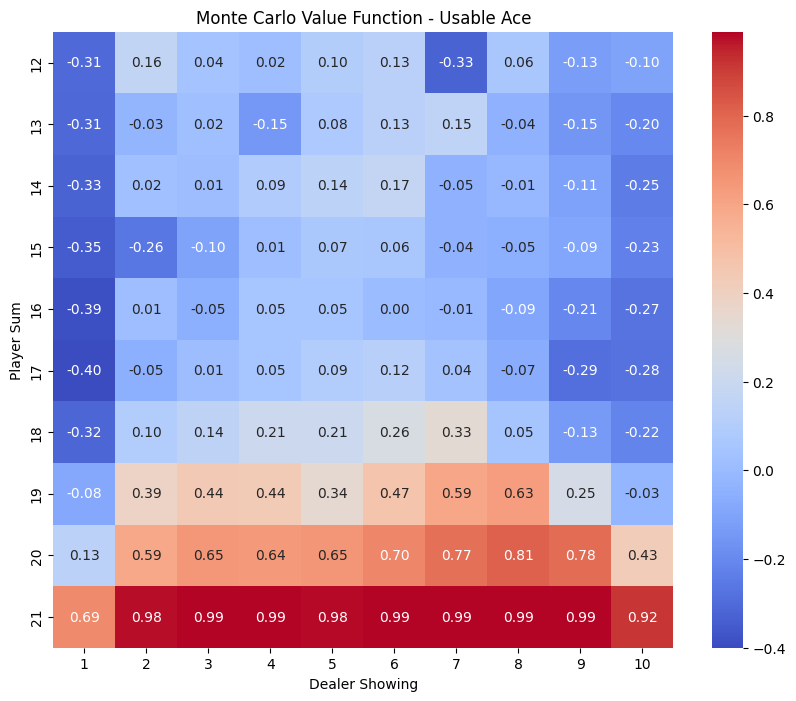

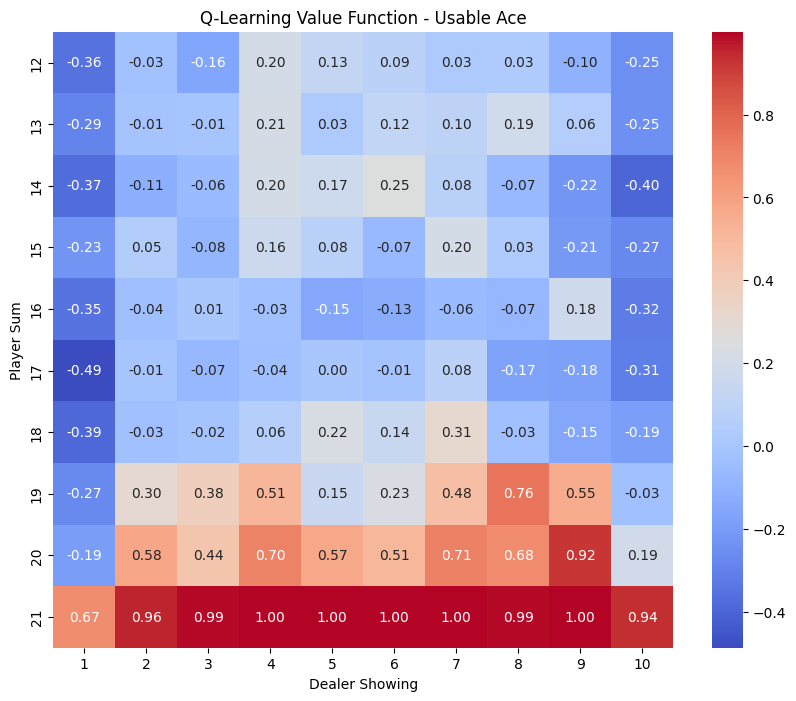

In [ ]:
# Use your value functions:
plot_value_function(V_double, title="Q-Learning Value Function", usable_ace=True)
plot_value_function(V_mc, title="Monte Carlo Value Function", usable_ace=True)
